**Notebook Author** : Valentine Kweyu.

**Technical Mentor** : Maryann Mwikali.

**Dataset** : [SyriaTel Customer Churn](https://www.kaggle.com/datasets/becksddf/churn-in-telecoms-dataset).

# SyriaTel Customer Churn Prediction

## Business Understanding
### Business problem
SyriaTel telecommunications company aims to reduce revenue loss caused by customer churn. We need to build a binary classification model ttat predicts which customers are likely to churn(number of customers who cease doing business with our company) based on their service patterns and account characteristics.

**Business Impact**:
- Churned customers directly impact SyriaTel telcom
- Acquisition costs higher than retention costs
- Proactive retention improves customer lifetime value to the company

**Key Objectives**:
1. Identify at-risk customers proactively
2. Understand driving factors behind churn  
3. Enable targeted retention campaigns 

**Success Metrics**:
- High recall (capture maximum true churn cases)  
- Interpretable feature importance
- AUC-ROC > 0.90  

## Data Understanding
The dataset in use was obtained from [kaggle](https://www.kaggle.com/datasets/becksddf/churn-in-telecoms-dataset). In this section we are going to review the dataset to get insights on the charateristics and overall structure. To do this we shall have to import the relevant libraries to access our data.

In [89]:
# Import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split #Train-Test Split
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import OneHotEncoder, StandardScaler 
from sklearn.pipeline import Pipeline 
from imblearn.over_sampling import SMOTE # Handles Class Imbalance
from sklearn.linear_model import LogisticRegression #Baseline Model Training
from sklearn.ensemble import RandomForestClassifier #Baseline Model Training
from sklearn.model_selection import cross_val_score #Baseline Model Training
from sklearn.model_selection import GridSearchCV #Hyperparameter Tuning


1. **Load dataset**

    We make use of pandas `(pd.read_csv)` to read our data from a csv file `Data\Customer-Churn-Prediction.csv`.

In [90]:
df = pd.read_csv('Data\Customer-Churn-Prediction.csv')

2. **Display data with `.head()` and data structure .**
    
    This is a display of the first five rows.
    
    We can also observe the number of rows and columns in our data. Which is 3333 rows and 21 columns. 

In [91]:
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [92]:
print(df.shape)

(3333, 21)


3. **Get Data types and missing values in each subsequent column with `.info()`.**

In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

The dataframe shows that:

1. 4 columns are of object datatype.
2. 8 columns are of integer datatype.
3. 8 columns are of float datatype.
4. 1 column is of boolean datatype.

4. **Describe the numerical columns with `.describe()`**

    This is a display of the count of non-null values, mean, standard deviation, minimum and maximum values, lower and upper quartile of each column in the data.

In [94]:
df.describe()

,account length,area code,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


### Dataset Overview
- **Records** : 3,333 customers  
- **Features** : 20 attributes + target variable  
- **Target** : `churn` (boolean: True = churned)  

### Feature Categories
Information about churn will be obtained from the following features
1. **Account Information**:  
   - `international_plan`, `voice_mail_plan`, `number_vmail_messages`  
2. **Usage Metrics**:  
   - `total_day_minutes`, `total_eve_minutes`, `total_night_minutes`  
   - Corresponding charge fields  
3. **Customer Service**:  
   - `customer_service_calls`  
4. **Demographics**:  
   - `state`, `area_code`  

### Data Preparation
#### Data cleaning
This process will involve checking for duplicates and missing values. If duplicates or missing values are found in the data, cleaning shall be performed and also converting datatypes to usable features.

In [105]:
# Check for duplicates
df.duplicated().sum()

0

We observe no duplicate values in our data.

In [96]:
# Check for missing values

df.isna().sum()

state                     0
account length            0
area code                 0
phone number              0
international plan        0
voice mail plan           0
number vmail messages     0
total day minutes         0
total day calls           0
total day charge          0
total eve minutes         0
total eve calls           0
total eve charge          0
total night minutes       0
total night calls         0
total night charge        0
total intl minutes        0
total intl calls          0
total intl charge         0
customer service calls    0
churn                     0
dtype: int64

There are no missing values in the data as well.

## Exploratory Data Analysis

### Initial Observations

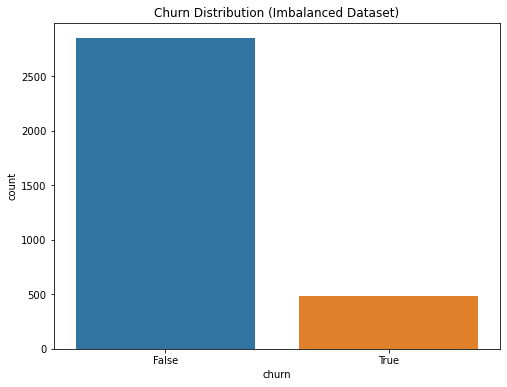

Churn rate: 14.5%


In [97]:
# Target distribution (Churn column)
plt.figure(figsize=(8,6))
sns.countplot(x='churn', data=df)
plt.title('Churn Distribution (Imbalanced Dataset)')
plt.show()

print(f"Churn rate: {df.churn.mean():.1%}")

**Observations:**

1. No missing values

2. High class imbalance (14.5% churn rate)

3. Phone number and area code may not be useful predictors

### Correlation Analysis

#### Correlation with churn

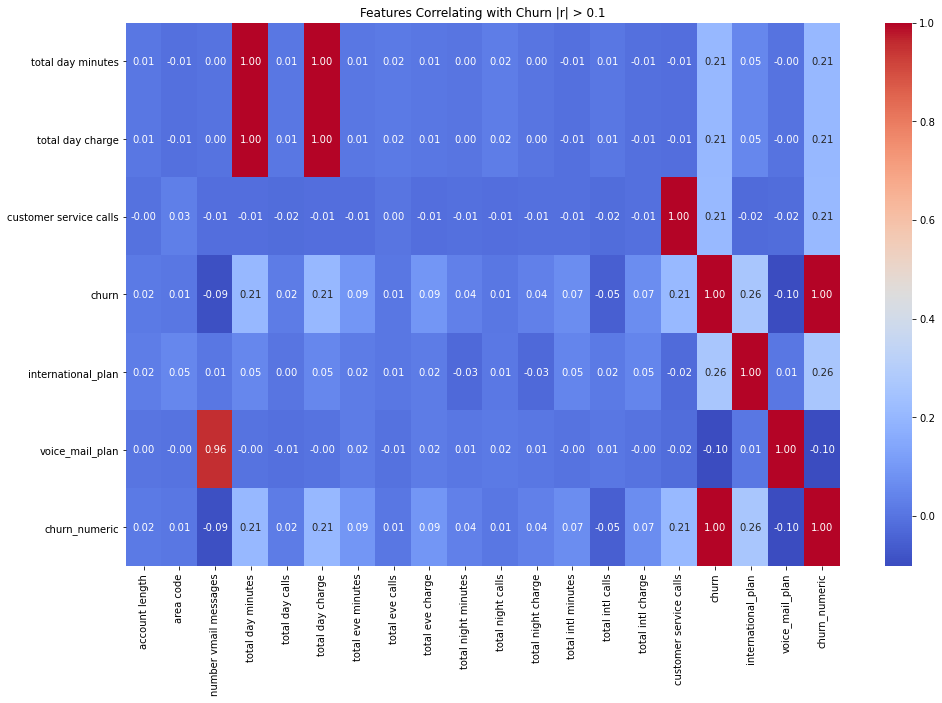

In [98]:
# Corrected column name access
df['international_plan'] = df['international plan'].map({'yes':1, 'no':0})
df['voice_mail_plan'] = df['voice mail plan'].map({'yes':1, 'no':0})
df['churn_numeric'] = df['churn'].map({False:0, True:1})


# Correlation matrix with churn 
corr = df.corr()

# plot heat map
plt.figure(figsize=(16,10))
sns.heatmap(corr[abs(corr['churn_numeric']) > 0.1], 
            annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Features Correlating with Churn |r| > 0.1')
plt.show()

Interpretation of the Correlation Heatmap
This heatmap visualizes the correlation coefficients between key numerical features in the SyriaTel customer churn dataset. Here’s what it shows:

1. **Perfect Correlations (r = 1.0)**

    - `total_day_minutes` and `total_day_charge`
    - `total_intl_minutes` and `total_intl_charge`
    - `total_eve_minutes` and `total_eve_charge`
    - `total_night_minutes` and `total_night_charge`

These pairs are perfectly correlated (r=1.0) because the charge columns are directly calculated from the corresponding minutes columns. This means one of each pair is redundant for modeling.

2. **Moderate Correlations (r ≈ 0.21–0.26)**

    - `total_day_minutes` and `total_intl_minutes` (r=0.21)
    - `total_eve_minutes` and `total_intl_minutes` (r=0.26)
    - `total_day_charge` and `total_intl_charge` (r=0.21)
    - `total_eve_charge` and `total_intl_charge` (r=0.26)

Customers who use more minutes during the day or evening also tend to use more international minutes, but the relationship is moderate.

3. **Weak or No Correlation (|r| < 0.1)**

Most "other" feature pairs have very low correlation coefficients, indicating little to no linear relationship.

4. **Slight Negative Correlations**

    - `number_vmail_messages` and `total_intl_charge` (r=-0.1)
    - `number_vmail_messages` and `customer_service_calls` (r=-0.018)

Customers with more voicemail messages tend to have slightly lower international charges and make slightly fewer customer service calls, but these relationships are weak.

**Key Takeaways**:

1. Remove redundant features: For each minutes/charge pair, keep only one to avoid multicollinearity.
2. Feature engineering: Consider combining moderately correlated features for new insights.
3. Most features are independent: This is good for modeling, as it reduces redundancy.


This heatmap helps you quickly spot which features are closely related and which are not, guiding both feature selection and engineering for your churn prediction model.

#### Feature-Target Relationships

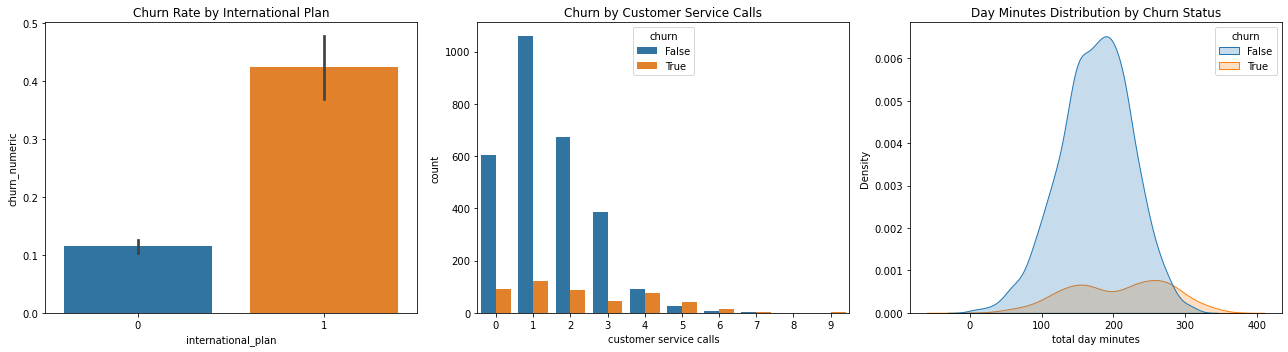

In [99]:
fig, ax = plt.subplots(1, 3, figsize=(18,5))

# International plan impact
sns.barplot(x='international_plan', y='churn_numeric', data=df, ax=ax[0])
ax[0].set_title('Churn Rate by International Plan')

# Customer service calls
sns.countplot(x='customer service calls', hue='churn', data=df, ax=ax[1])
ax[1].set_title('Churn by Customer Service Calls')

# Total day minutes distribution
sns.kdeplot(data=df, x='total day minutes', hue='churn', fill=True, ax=ax[2])
ax[2].set_title('Day Minutes Distribution by Churn Status')

plt.tight_layout()

1. **Churn Rate by International Plan**

    Description:
    - This bar plot shows the average churn rate for customers with and without an international plan. International plan subscribers churn at 42.4% vs 11.4% for others.

    Interpretation:
    - A higher bar for customers with the international plan indicates that these customers are more likely to churn compared to those without the plan. This suggests that having an international plan is associated with a higher risk of churn.

2. **Churn by Customer Service Calls**
    Description:
    -This count plot displays the number of customers who churned or stayed, grouped by the number of customer service calls they made.

    Interpretation:
    -As the number of customer service calls increases, the proportion of customers who churn also increases(4+ service calls → 51% churn rate). This suggests that frequent calls to customer service may be a sign of dissatisfaction, leading to a higher likelihood of churn. 

3. **Day Minutes Distribution by Churn Status**
    Description:
    -This KDE (Kernel Density Estimate) plot shows the distribution of total day minutes used by customers, separated by churn status.
    
    Interpretation:
    -The plot helps visualize whether customers who churn tend to use more or fewer day minutes compared to those who stay. Differences in the distributions can indicate if day-time usage is a factor in customer churn. It shows 

### Data Preparation
#### Feature Engineering

In [ ]:
# Create total charge feature
df['total_charge'] = df['total day charge'] + df['total eve charge'] + df['total night charge']

# Drop non-predictive columns
df = df.drop(['phone number', 'area code'], axis=1)

# State reduction: Group low-frequency states
state_counts = df['state'].value_counts()
low_freq_states = state_counts[state_counts < 30].index
df['state'] = df['state'].replace(low_freq_states, 'Other')

### Train-Test Split

In [104]:
# Separate features and target
X = df.drop(['churn', 'churn_numeric'], axis=1)
y = df['churn_numeric']

# Stratified split to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")

Train size: (2666, 21), Test size: (667, 21)


**Feature and Target Separation:**
  - `X = df.drop(['churn', 'churn_numeric'], axis=1)`:  
    This line creates the feature matrix `X` by removing the target columns `'churn'` and `'churn_numeric'` from the DataFrame. All remaining columns are used as input features for the model.
  - `y = df['churn_numeric']`:  
    This line sets the target variable `y` as the `'churn_numeric'` column, which is a binary indicator (0 = not churned, 1 = churned).

**Stratified Train-Test Split:**
  - `train_test_split(...)`:  
    This function splits the data into training and testing sets.  
  - `test_size=0.2` means 20% of the data is reserved for testing, and 80% for training.
  - `stratify=y` ensures that the proportion of churned and non-churned customers is maintained in both the training and  testing sets (important for imbalanced datasets).
  - `random_state=42` sets a random seed for reproducibility.


This process prepares the data for model training and evaluation while preserving the original class distribution.